### - Read test COCO image & object boxes & class

In [1]:
import PIL.Image as pilimg
import numpy as np
from matplotlib.pyplot import imshow

size of img: (426, 640, 3)
img: [[[  8   9   4]
  [  8   9   4]
  [  7   8   3]
  ...
  [ 59  60  64]
  [ 58  57  65]
  [ 71  69  80]]

 [[  8   9   4]
  [  8   9   4]
  [  7   8   3]
  ...
  [151 150 155]
  [148 147 153]
  [150 149 157]]

 [[  8   9   4]
  [  7   8   3]
  [  7   8   3]
  ...
  [187 187 189]
  [180 179 184]
  [172 171 176]]

 ...

 [[191 189  86]
  [174 166  68]
  [148 132  44]
  ...
  [154 120  93]
  [140 106  78]
  [133 100  69]]

 [[192 186  92]
  [154 159  69]
  [137 134  39]
  ...
  [126  96  72]
  [145 115  91]
  [139 109  83]]

 [[136 129  38]
  [119 123  36]
  [120 117  24]
  ...
  [127  97  73]
  [145 115  91]
  [139 109  83]]]


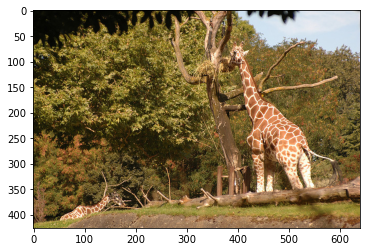

In [2]:
img_path = './COCO_train2014_000000000025.jpg'

# Read image
img = pilimg.open(img_path)
img = np.array(img)

# Show test image
print('size of img:', img.shape)
print('img:', img)
imshow(img)

In [3]:
def load_coco_names(path):
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names

label_path = './COCO_train2014_000000000025.txt'
coco_names_path = './coco.names'
coco_names = load_coco_names(coco_names_path)

# Object box list
obj_box_list = []

# Class list
class_list = []

# Read label & get object box and class
try:
    file = open(label_path, mode='r', encoding='utf-8')
    while True:
        line = file.readline().rstrip()
        if not line: break
            
        split_line = np.array(line.split(' '))
        split_line = list(map(float, split_line))
        
        # Object box
        obj_box_list.append(split_line[1:])
        
        # Class index to name
        class_name = coco_names[int(split_line[0])]
        class_list.append(class_name)
finally:
    file.close()
    
obj_box_list = np.array(obj_box_list)
class_list = np.array(class_list)

# Show label
# x/y/w/h format, relative scale
print('obj_box_list:', obj_box_list)
print('class_list:', class_list)

data = (img, obj_box_list, class_list)

obj_box_list: [[0.770336 0.489695 0.335891 0.697559]
 [0.185977 0.901608 0.206297 0.129554]]
class_list: ['giraffe' 'giraffe']


### - Processing for drawing object boxes
    1. Convert relative scale to absolute scale of object boxes
    2. Convert x/y/w/h format to x/y/x/y format of object boxes
    3. Draw object boxes

In [4]:
import numpy as np
import cv2
import copy

import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [5]:
# Convert relative scale to absolute scale of object boxes
class ToAbsoluteScale(object):
    def __init__(self):
        pass
    
    def __call__(self, data):
        img, obj_boxes, obj_classes = data
        h, w, _ = img.shape
        obj_boxes[:, [0, 2]] *= w
        obj_boxes[:, [1, 3]] *= h
        return img, obj_boxes, obj_classes

TRANSFORMS_AbsoluteScale = transforms.Compose([
    ToAbsoluteScale()
])

print('Boxes of relative scale:', data[1])

TRANSFORMS_AbsoluteScale_data = TRANSFORMS_AbsoluteScale(data)
print('Boxes of absolute scale:', TRANSFORMS_AbsoluteScale_data[1])

Boxes of relative scale: [[0.770336 0.489695 0.335891 0.697559]
 [0.185977 0.901608 0.206297 0.129554]]
Boxes of absolute scale: [[493.01504  208.61007  214.97024  297.160134]
 [119.02528  384.085008 132.03008   55.190004]]


x1/x2/x3/x4: 385, 60, 600, 357
class idx: giraffe
x1/x2/x3/x4: 53, 356, 185, 411
class idx: giraffe


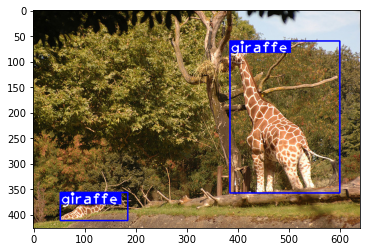

In [6]:
# Convert x/y/w/h format to x/y/x/y format of object boxes
def xywh2xyxy_np(x):
    y = np.zeros_like(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

# Draw object boxes
def draw_object_boxes(data):
    
    img, obj_box_list, class_list = data
    
    for i, (obj_box, class_name) in enumerate(zip(obj_box_list, class_list)):
        obj_box = xywh2xyxy_np(obj_box)
        x1, y1, x2, y2 = list(map(int, obj_box))
        
        print(f'x1/x2/x3/x4: {x1}, {y1}, {x2}, {y2}')
        print(f'class idx: {class_name}')
        
        color = (0, 0, 255)
        thickness = 2
        
        t_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_PLAIN, 2 , 2)[0]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        cv2.rectangle(img, (x1, y1), (x1+t_size[0]+3, y1+t_size[1]+4), color, -1)
        cv2.putText(img, class_name, (x1, y1+t_size[1]+4), cv2.FONT_HERSHEY_PLAIN, 2, [255,255,255], 2)

        imshow(img)

draw_object_boxes(copy.deepcopy(data))